In [1]:
import scanpy as sc
import multimil as mtm
import anndata as ad
import numpy as np
import scib

sc.set_figure_params(dpi=100, frameon=False, facecolor=None, transparent=True)

[rank: 0] Global seed set to 0
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
%load_ext autoreload
%autoreload 2

## Try disease prediction

### MultiMIL without single atac

In [26]:
adata = sc.read_h5ad('/home/icb/zihe.zheng/projects/microglia/data/integrated_only_rna.h5ad')

In [27]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [28]:
rna_mtg = sc.read_h5ad('/home/icb/zihe.zheng/projects/microglia/data/SEAAD/reduced_microglia_SEAAD_MTG_RNAseq.h5ad')
rna_dlpfc = sc.read_h5ad('/home/icb/zihe.zheng/projects/microglia/data/SEAAD/reduced_microglia_SEAAD_DLPFC_RNA.h5ad')
rna_sun = sc.read_h5ad('/home/icb/zihe.zheng/projects/microglia/data/SUN/reduced_microglia_MIT_ROSMAP_RNA.h5ad')

In [29]:
adata_cat = ad.concat([rna_mtg, rna_dlpfc])

In [30]:
ad_dict1 = rna_sun.obs['ADdiag3types'].to_dict()
adata.obs['ADdiag3types'] = adata.obs.index.map(ad_dict1)

ad_dict2 = adata_cat.obs['Overall AD neuropathological Change'].to_dict()
adata.obs['Overall AD neuropathological Change'] = adata.obs.index.map(ad_dict2)

In [31]:
ad_dict3 = rna_sun.obs['subject'].to_dict()
adata.obs['subject'] = adata.obs.index.map(ad_dict3)

ad_dict4 = adata_cat.obs['Donor ID'].to_dict()
adata.obs['Donor ID'] = adata.obs.index.map(ad_dict4)

In [32]:
adata.obs = adata.obs.astype(str)

In [33]:
adata.obs['AD'] = np.where(
    (adata.obs['ADdiag3types'] == 'nonAD') | (adata.obs['Overall AD neuropathological Change'].isin(['Not AD', 'Reference'])),
    'healthy',  # Value if condition is True
    'AD'  # Value if condition is False, adjust this as necessary
)

In [35]:
# Convert 'Donor ID' and 'subject' columns to categorical data type
adata.obs['Donor ID'] = adata.obs['Donor ID'].astype('category')
adata.obs['subject'] = adata.obs['subject'].astype('category')

# Ensure both categorical columns have the same categories
combined_categories = adata.obs['Donor ID'].cat.categories.union(adata.obs['subject'].cat.categories)

# Set the combined categories for both columns
adata.obs['Donor ID'] = adata.obs['Donor ID'].cat.set_categories(combined_categories)
adata.obs['subject'] = adata.obs['subject'].cat.set_categories(combined_categories)

# Fill NaN values in 'Donor ID' with values from 'subject'
adata.obs['Donor ID'] = adata.obs['Donor ID'].mask(adata.obs['Donor ID'] == 'nan', adata.obs['subject'])


In [37]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()

In [38]:
new_adata.obsm = adata.obsm.copy()

(array([360.,  39.,  34.,  33.,  19.,  15.,  10.,   0.,   2.,   3.]),
 array([   0. ,  344.9,  689.8, 1034.7, 1379.6, 1724.5, 2069.4, 2414.3,
        2759.2, 3104.1, 3449. ]),
 <BarContainer object of 10 artists>)

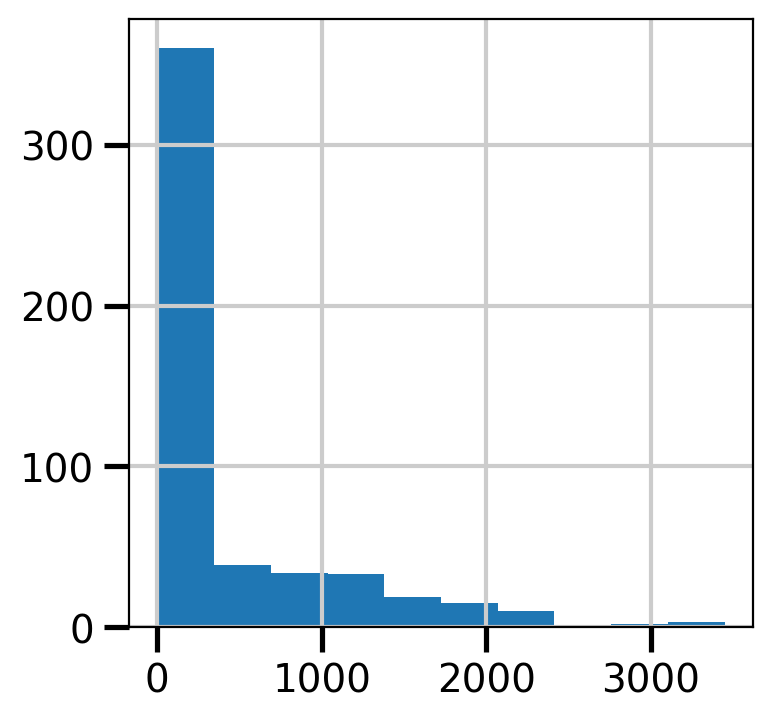

In [39]:
# number of cells per donor varies a lot
import matplotlib.pyplot as plt
plt.hist(adata.obs['Donor ID'].value_counts())

In [40]:
mask = adata.obs['Donor ID'].value_counts() > 100
samples = list(mask[mask].index)

In [41]:
sample_key = 'Donor ID'

In [42]:
# samples = np.unique(adata.obs[sample_key])
n_samples = len(samples)
query_proportion = 0.2

In [45]:
query_samples = np.load('query_samples.npy')

In [47]:
# rng = np.random.default_rng(0)
# query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)

In [48]:
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()

query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

In [54]:
classification_keys = ["AD"]
z_dim = 30
sample_key = 'Donor ID'
categorical_covariate_keys = classification_keys + [sample_key]

In [50]:
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()

idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

In [51]:
mtm.model.MILClassifier.setup_anndata(
    adata,
    categorical_covariate_keys=categorical_covariate_keys,
)

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['Donor ID'] has fewer than 3 cells. Models may not train properly.
  war

In [55]:
mil = mtm.model.MILClassifier(
    adata,
    classification=classification_keys,
    z_dim=z_dim,
    sample_key=sample_key,
    class_loss_coef=0.1,
)

In [56]:
mil.train(lr=1e-3)

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/zihe.zheng/miniconda3/envs/multimil/lib/py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/zihe.zheng/miniconda3/envs/multimil/lib/py ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-PC

Epoch 1/200:   0%|                                                                          | 0/200 [00:00<?, ?it/s]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 3/200:   1%|▍                                           | 2/200 [00:24<36:06, 10.94s/it, loss=0.0355, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 4/200:   2%|▋                                           | 3/200 [00:27<24:27,  7.45s/it, loss=0.0286, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 5/200:   2%|▉                                           | 4/200 [00:31<18:57,  5.80s/it, loss=0.0144, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 6/200:   2%|█▏                                           | 5/200 [00:34<15:53,  4.89s/it, loss=0.025, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 7/200:   3%|█▎                                          | 6/200 [00:37<14:05,  4.36s/it, loss=0.0116, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 8/200:   4%|█▌                                          | 7/200 [00:41<12:55,  4.02s/it, loss=0.0101, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 9/200:   4%|█▊                                          | 8/200 [00:44<12:08,  3.80s/it, loss=0.0142, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 10/200:   4%|█▉                                         | 9/200 [00:47<11:34,  3.64s/it, loss=0.0101, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 11/200:   5%|██                                       | 10/200 [00:50<11:10,  3.53s/it, loss=0.00766, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 12/200:   6%|██▎                                       | 11/200 [00:54<10:53,  3.46s/it, loss=0.0135, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 13/200:   6%|██▍                                      | 12/200 [00:57<10:40,  3.41s/it, loss=0.00641, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 14/200:   6%|██▋                                       | 13/200 [01:00<10:30,  3.37s/it, loss=0.0103, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 15/200:   7%|██▊                                      | 14/200 [01:04<10:22,  3.35s/it, loss=0.00711, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 16/200:   8%|███▏                                       | 15/200 [01:07<10:16,  3.33s/it, loss=0.014, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 17/200:   8%|███▎                                      | 16/200 [01:12<11:25,  3.73s/it, loss=0.0183, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 18/200:   8%|███▍                                     | 17/200 [01:15<10:58,  3.60s/it, loss=0.00463, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 19/200:   9%|███▋                                     | 18/200 [01:18<10:38,  3.51s/it, loss=0.00142, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 20/200:  10%|███▉                                      | 19/200 [01:22<10:37,  3.52s/it, loss=0.0164, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 21/200:  10%|████▏                                     | 20/200 [01:26<11:14,  3.75s/it, loss=0.0188, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 22/200:  10%|████▏                                   | 21/200 [01:29<10:47,  3.62s/it, loss=0.000998, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 23/200:  11%|████▌                                    | 22/200 [01:33<10:25,  3.52s/it, loss=0.00403, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 24/200:  12%|████▊                                     | 23/200 [01:36<10:09,  3.44s/it, loss=0.0073, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 25/200:  12%|████▉                                    | 24/200 [01:39<09:56,  3.39s/it, loss=0.00341, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 26/200:  12%|█████▏                                   | 25/200 [01:42<09:46,  3.35s/it, loss=0.00314, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 27/200:  13%|█████▎                                   | 26/200 [01:46<09:38,  3.32s/it, loss=0.00904, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 28/200:  14%|█████▌                                   | 27/200 [01:52<11:57,  4.15s/it, loss=0.00318, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 29/200:  14%|█████▉                                    | 28/200 [01:55<11:27,  4.00s/it, loss=0.0136, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 30/200:  14%|█████▉                                   | 29/200 [01:59<10:44,  3.77s/it, loss=0.00141, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 31/200:  15%|██████                                  | 30/200 [02:02<10:28,  3.69s/it, loss=0.000506, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 32/200:  16%|██████▌                                   | 31/200 [02:07<11:08,  3.96s/it, loss=0.0017, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 33/200:  16%|██████▌                                  | 32/200 [02:10<10:29,  3.75s/it, loss=0.00325, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 34/200:  16%|██████▊                                  | 33/200 [02:13<10:00,  3.59s/it, loss=0.00234, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 35/200:  17%|██████▉                                  | 34/200 [02:16<09:41,  3.50s/it, loss=0.00362, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 36/200:  18%|███████▎                                  | 35/200 [02:20<09:57,  3.62s/it, loss=0.0111, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 37/200:  18%|███████▌                                  | 36/200 [02:25<10:45,  3.93s/it, loss=0.0072, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 38/200:  18%|███████▌                                 | 37/200 [02:28<10:13,  3.76s/it, loss=0.00275, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 39/200:  19%|███████▊                                 | 38/200 [02:32<09:45,  3.62s/it, loss=0.00616, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 40/200:  20%|███████▉                                 | 39/200 [02:35<09:24,  3.51s/it, loss=0.00173, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 41/200:  20%|████████▏                                | 40/200 [02:38<09:09,  3.43s/it, loss=0.00172, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 42/200:  20%|████████▌                                 | 41/200 [02:43<10:27,  3.94s/it, loss=0.0133, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 43/200:  21%|████████▌                                | 42/200 [02:48<11:13,  4.26s/it, loss=0.00223, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 44/200:  22%|████████▊                                | 43/200 [02:53<11:29,  4.39s/it, loss=0.00149, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 44/200:  22%|████████▊                               | 44/200 [03:01<14:31,  5.59s/it, loss=0.000889, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 46/200:  22%|█████████▏                               | 45/200 [03:06<14:01,  5.43s/it, loss=0.00195, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 47/200:  23%|█████████▏                              | 46/200 [03:11<13:21,  5.20s/it, loss=8.34e-05, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 48/200:  24%|█████████▍                              | 47/200 [03:14<11:45,  4.61s/it, loss=0.000873, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 49/200:  24%|█████████▊                               | 48/200 [03:18<10:39,  4.21s/it, loss=0.00137, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 50/200:  24%|██████████                               | 49/200 [03:21<09:52,  3.92s/it, loss=0.00241, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 51/200:  25%|██████████▎                              | 50/200 [03:25<10:16,  4.11s/it, loss=0.00402, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 52/200:  26%|██████████▍                              | 51/200 [03:30<10:29,  4.22s/it, loss=0.00329, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 53/200:  26%|██████████▋                              | 52/200 [03:35<10:46,  4.37s/it, loss=0.00053, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 54/200:  26%|██████████▊                              | 53/200 [03:38<09:53,  4.04s/it, loss=0.00184, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 55/200:  27%|██████████▊                             | 54/200 [03:41<09:15,  3.81s/it, loss=1.02e-05, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 55/200:  28%|███████████▎                             | 55/200 [03:44<09:53,  4.09s/it, loss=0.00203, v_num=1]

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)



Monitored metric accuracy_validation did not improve in the last 50 records. Best score: 1.000. Signaling Trainer to stop.


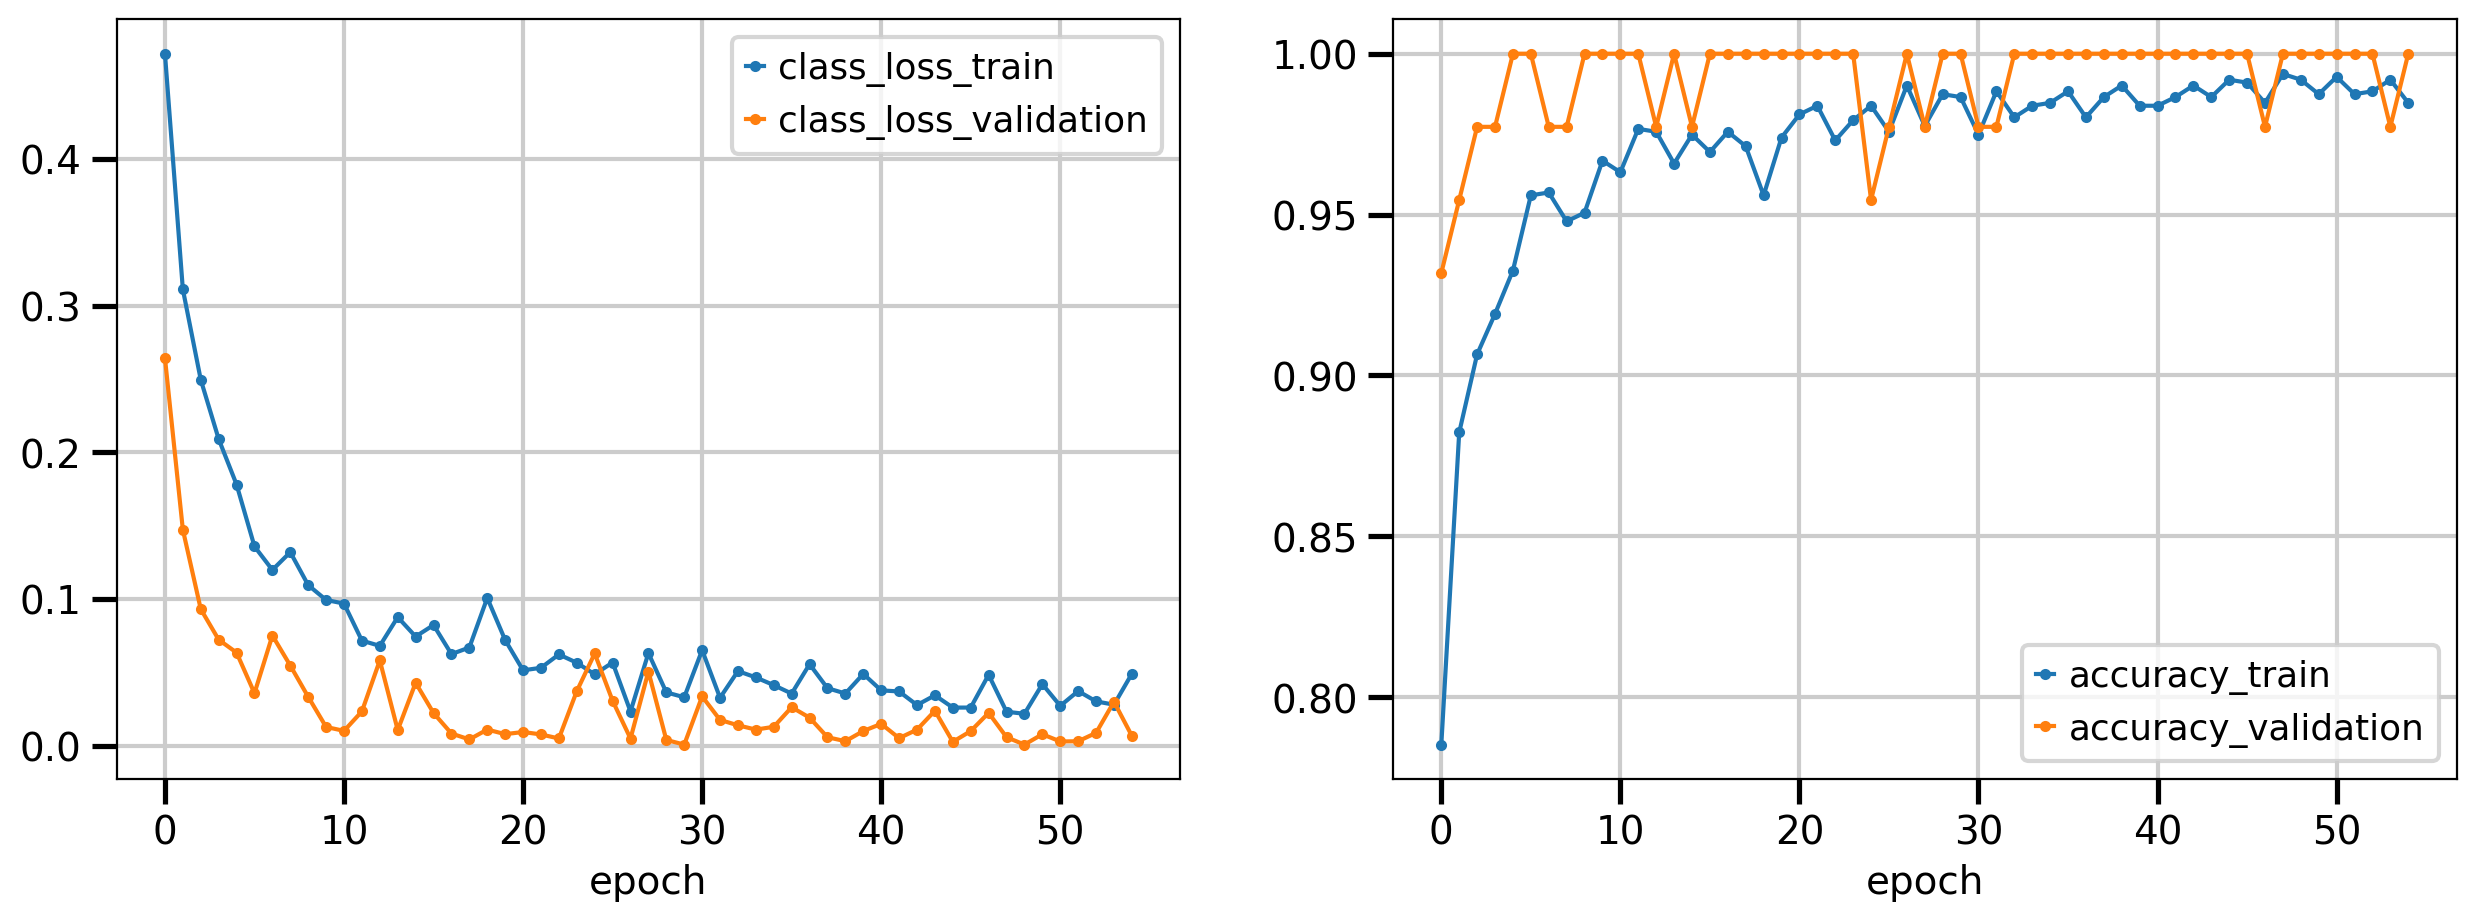

In [57]:
mil.plot_losses()

In [58]:
mil.get_model_output()
adata

AnnData object with n_obs × n_vars = 185383 × 30
    obs: 'batch', '_scvi_batch', '_scvi_labels', 'ADdiag3types', 'Overall AD neuropathological Change', 'subject', 'Donor ID', 'AD', 'ref', 'cell_attn', 'bags', 'predicted_AD'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_AD', 'bag_full_predictions_AD'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'full_predictions_AD'

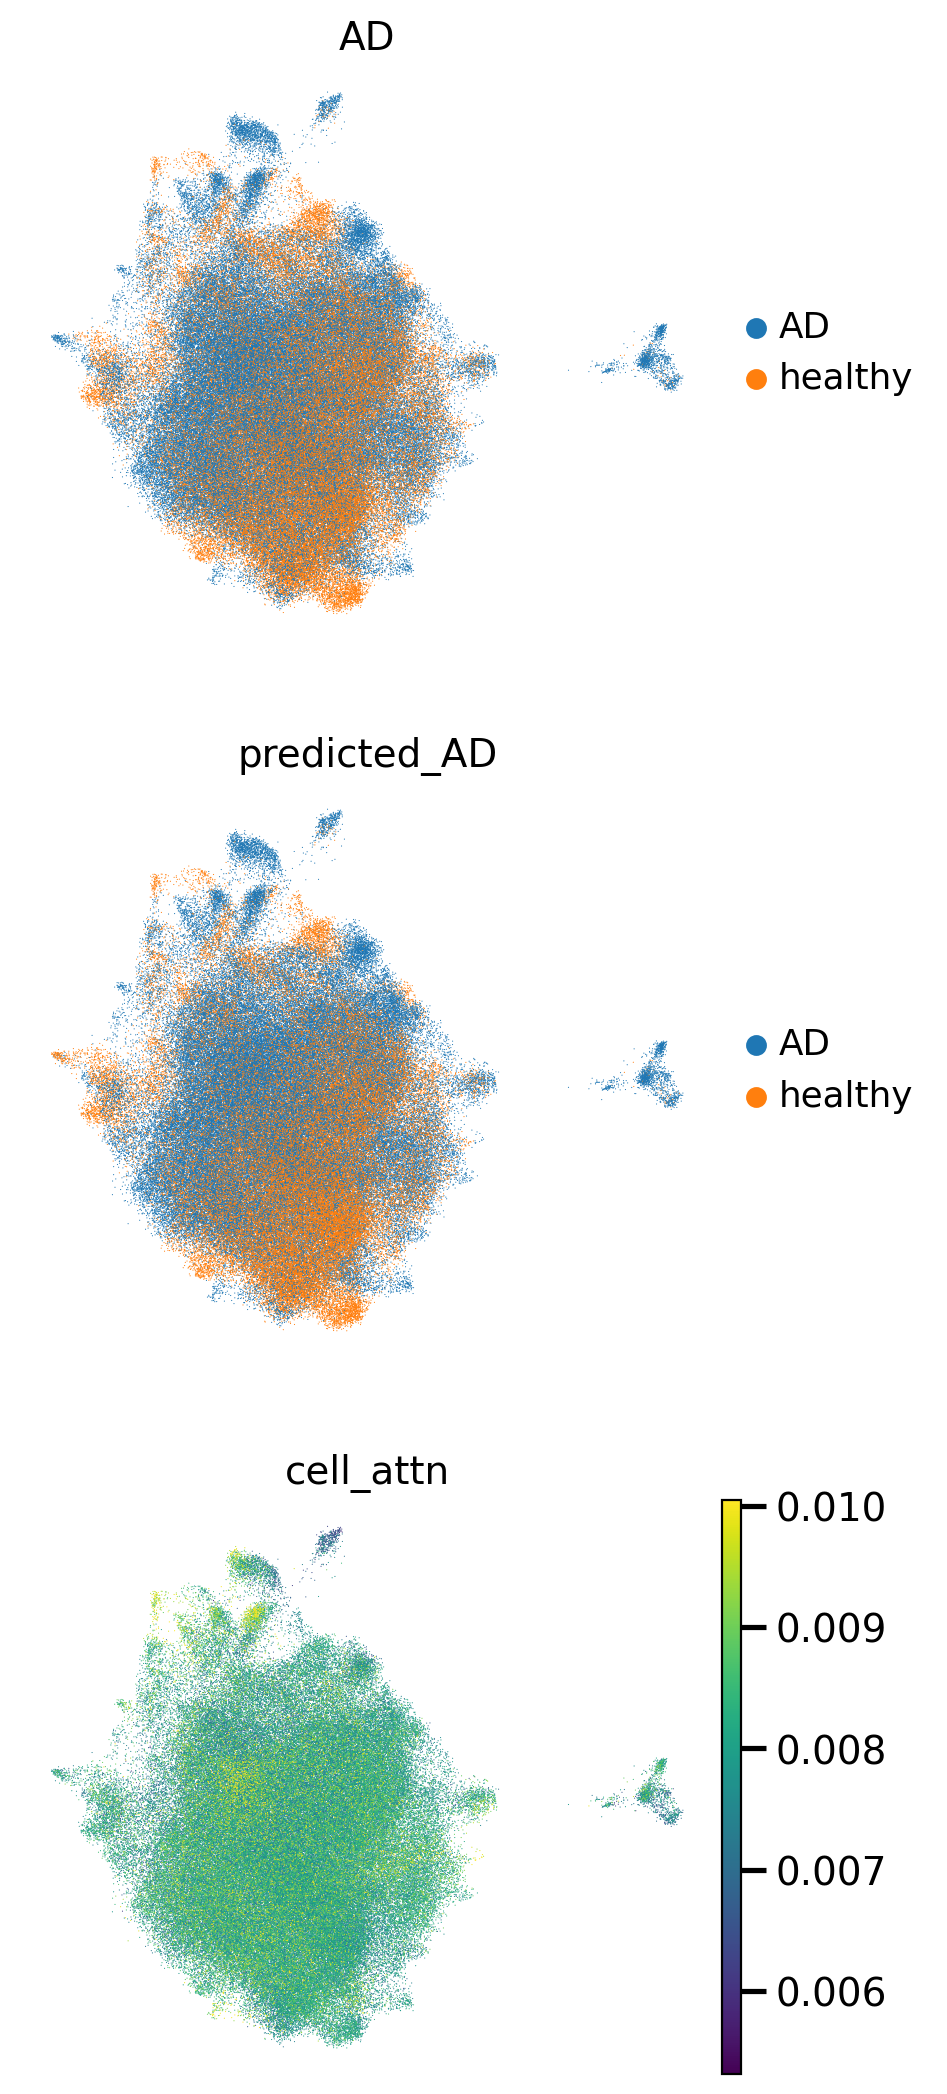

In [59]:
sc.pl.umap(adata, color=["AD", "predicted_AD", "cell_attn"], ncols=1, frameon=False, vmax="p99")

In [60]:
new_model = mtm.model.MILClassifier.load_query_data(query, mil)

/home/icb/zihe.zheng/miniconda3/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [61]:
new_model.get_model_output()
query

AnnData object with n_obs × n_vars = 49562 × 30
    obs: 'batch', '_scvi_batch', '_scvi_labels', 'ADdiag3types', 'Overall AD neuropathological Change', 'subject', 'Donor ID', 'AD', 'ref', 'cell_attn', 'bags', 'predicted_AD'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_AD', 'bag_full_predictions_AD'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'full_predictions_AD'

In [62]:
adata_both = ad.concat([adata, query])

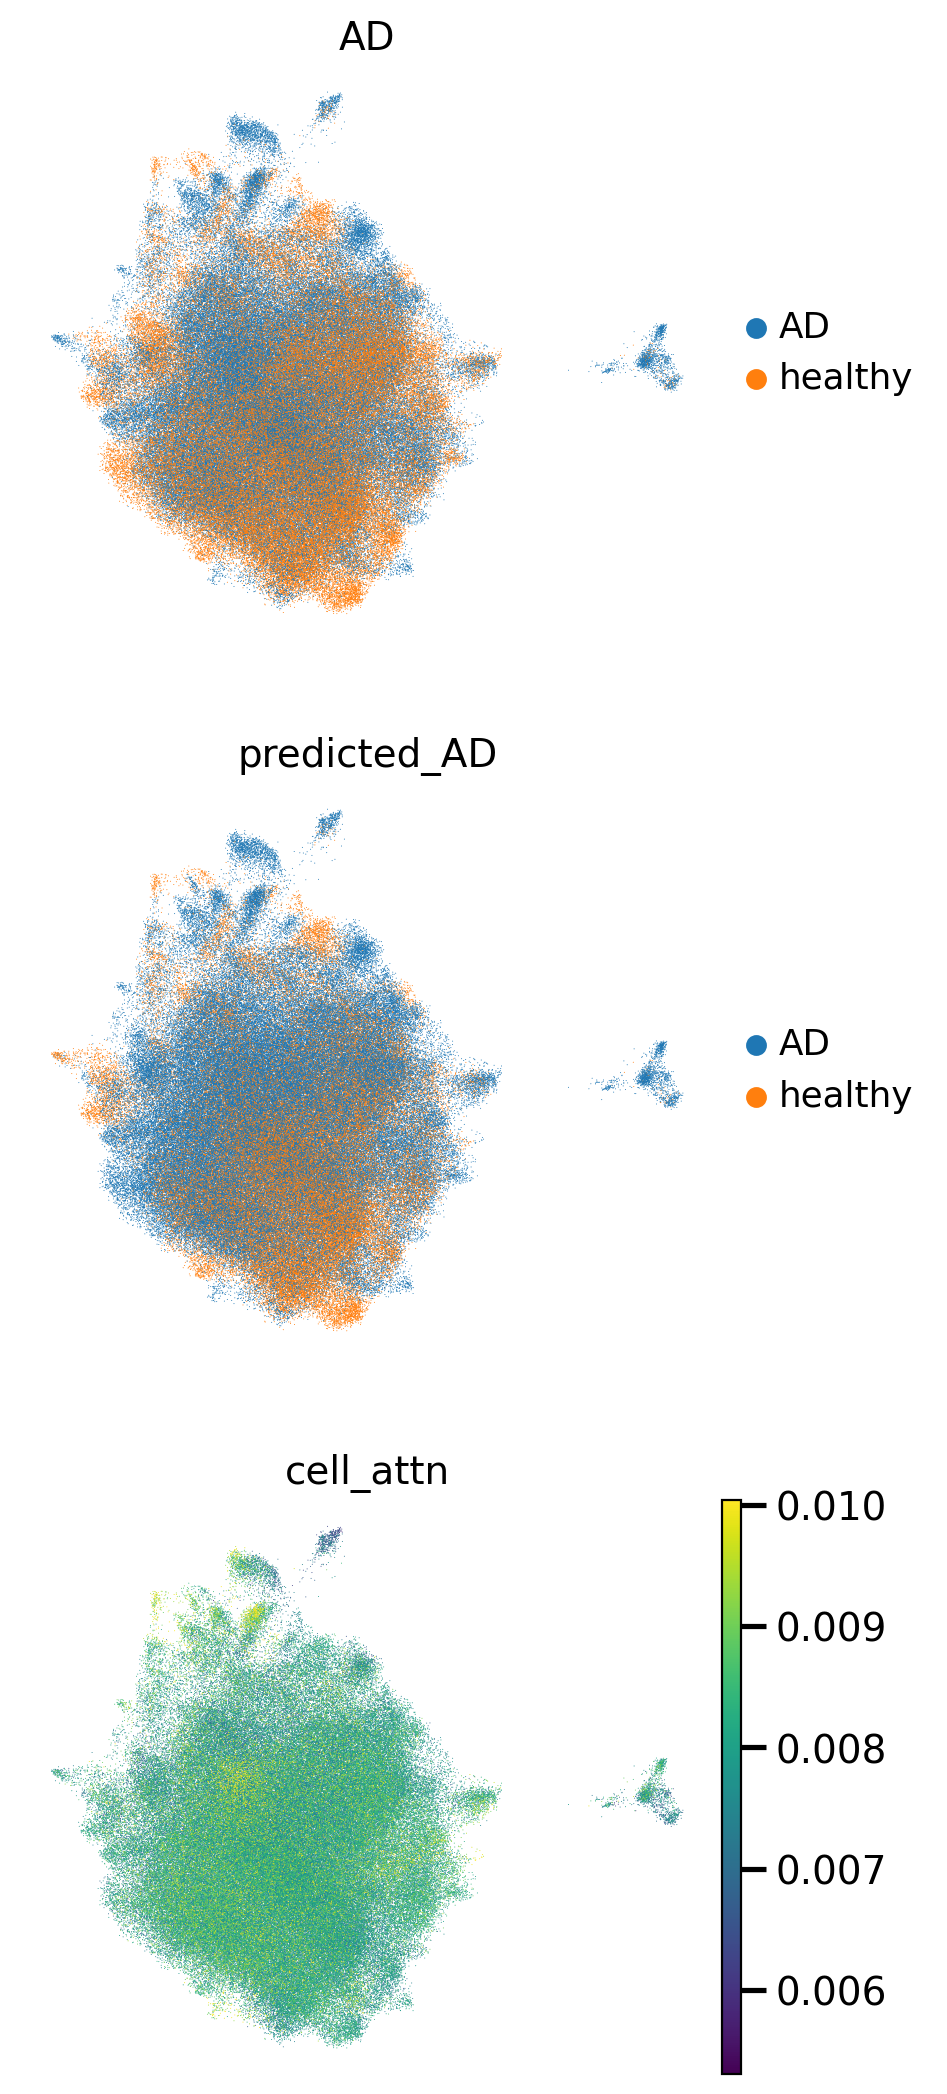

In [63]:
sc.pl.umap(adata_both, color=["AD", "predicted_AD", "cell_attn"], ncols=1, frameon=False, vmax="p99")

In [64]:
from sklearn.metrics import classification_report

print(classification_report(query.obs["AD"], query.obs["predicted_AD"]))

              precision    recall  f1-score   support

          AD       0.38      0.68      0.49     21312
     healthy       0.42      0.17      0.24     28250

    accuracy                           0.39     49562
   macro avg       0.40      0.43      0.37     49562
weighted avg       0.40      0.39      0.35     49562



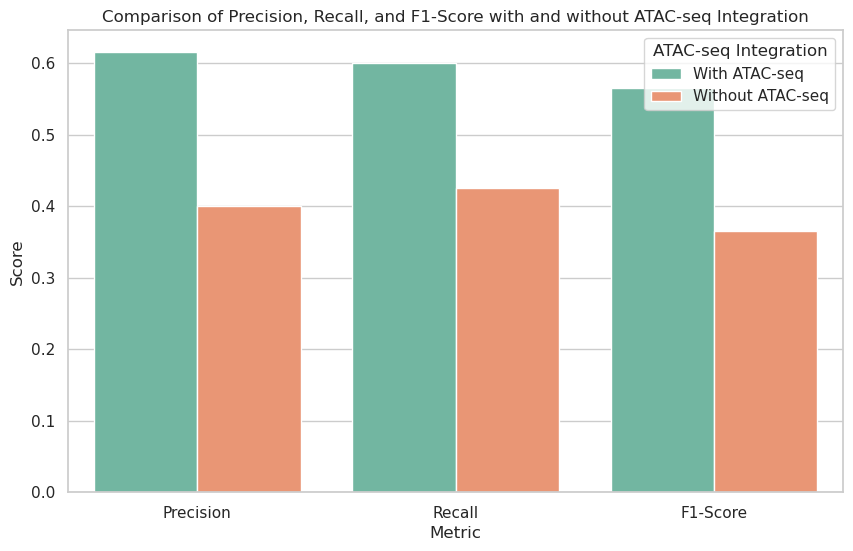

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the images
data = {
    'Condition': ['AD', 'AD', 'AD', 'Healthy', 'Healthy', 'Healthy'],
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Precision', 'Recall', 'F1-Score'],
    'With ATAC-seq': [0.50, 0.80, 0.62, 0.73, 0.40, 0.51],
    'Without ATAC-seq': [0.38, 0.68, 0.49, 0.42, 0.17, 0.24]
}

# Convert data into a DataFrame
df = pd.DataFrame(data)

# Convert DataFrame to long format for plotting
df_long = pd.melt(df, id_vars=['Condition', 'Metric'], value_vars=['With ATAC-seq', 'Without ATAC-seq'],
                  var_name='ATAC-seq Integration', value_name='Score')

# Set the plot style
sns.set(style="whitegrid")

# Create a side-by-side barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='ATAC-seq Integration', data=df_long, palette='Set2'
            , dodge=True, errorbar = None)

# Add title and labels
plt.title('Comparison of Precision, Recall, and F1-Score with and without ATAC-seq Integration')
plt.ylabel('Score')
plt.xlabel('Metric')

# Show the plot
plt.show()
